## Import and libraries

In [1]:
!pip install evaluate
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import evaluate
import plotly.express as px
from matplotlib import pyplot as plt
import keras
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import Dense, Dropout, Input, Convolution2D, BatchNormalization, Activation, MaxPool2D, Flatten, Conv1D, MaxPooling1D, Reshape
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import random as python_random
from collections import Counter

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import random

In [3]:
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

## Dataset

In [4]:
from datasets import load_dataset

gtzan = load_dataset("marsyas/gtzan", "all", trust_remote_code=True)
gtzan

README.md:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

gtzan.py:   0%|          | 0.00/3.35k [00:00<?, ?B/s]

genres.tar.gz:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})

In [5]:
seed = 42
df = gtzan['train'].train_test_split(seed = seed, shuffle = True, test_size = .2)
df

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 799
    })
    test: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 200
    })
})

In [6]:
df['train']

Dataset({
    features: ['file', 'audio', 'genre'],
    num_rows: 799
})

In [7]:
temp = df['test'].train_test_split(seed = seed, shuffle = True, test_size = .5)
df['validation'] = temp['train']
df['test'] = temp['test']
print(df['validation'].shape, df['test'].shape)

(100, 3) (100, 3)


Split dataset into training (80%) and test set (20%)

### Inspect

In [8]:
id = 5
print("file:", df['train'][id]['file'])
print('\n')
print("audio: ", df['train'][id]['audio'])
print('\n')
print("genre:", df['train'][id]['genre'])
print('\n')

file: /root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/classical/classical.00020.wav


audio:  {'path': '/root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/classical/classical.00020.wav', 'array': array([-0.05187988, -0.06655884, -0.04104614, ...,  0.08074951,
        0.06646729,  0.04180908]), 'sampling_rate': 22050}


genre: 1




In [9]:
df['train'][id]['audio']['array']

array([-0.05187988, -0.06655884, -0.04104614, ...,  0.08074951,
        0.06646729,  0.04180908])

The following information are retrieved:
*   file = audio path
*   audio = represented by 1 dimensional array and relative sampling rate of 22,050 Hz
*   genre = family of song (integer)



In [10]:
id2label_function = df['train'].features['genre'].int2str

# Collect all unique genre IDs
unique_genre_ids = set([sample['genre'] for sample in df['train']])

# Create a mapping of genre IDs to labels
genre_mapping = {genre_id: id2label_function(genre_id) for genre_id in unique_genre_ids}

# Display the distinct genres with their IDs
print("Distinct Genres and their IDs:")
for genre_id, genre_label in sorted(genre_mapping.items()):
    print(f"ID: {genre_id}, Genre: {genre_label}")

Distinct Genres and their IDs:
ID: 0, Genre: blues
ID: 1, Genre: classical
ID: 2, Genre: country
ID: 3, Genre: disco
ID: 4, Genre: hiphop
ID: 5, Genre: jazz
ID: 6, Genre: metal
ID: 7, Genre: pop
ID: 8, Genre: reggae
ID: 9, Genre: rock


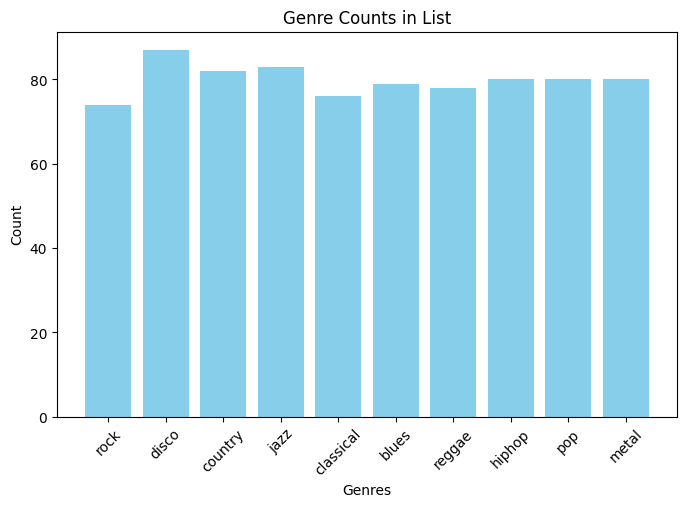

In [11]:
train_genres = []

for sample in df['train']:
    genre_label = id2label_function(sample['genre'])
    train_genres.append(genre_label)

genre_counts = Counter(train_genres)
labels, values = zip(*genre_counts.items())

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='skyblue')
plt.xlabel("Genres")
plt.ylabel("Count")
plt.title("Genre Counts in List")
plt.xticks(rotation=45)
plt.show()

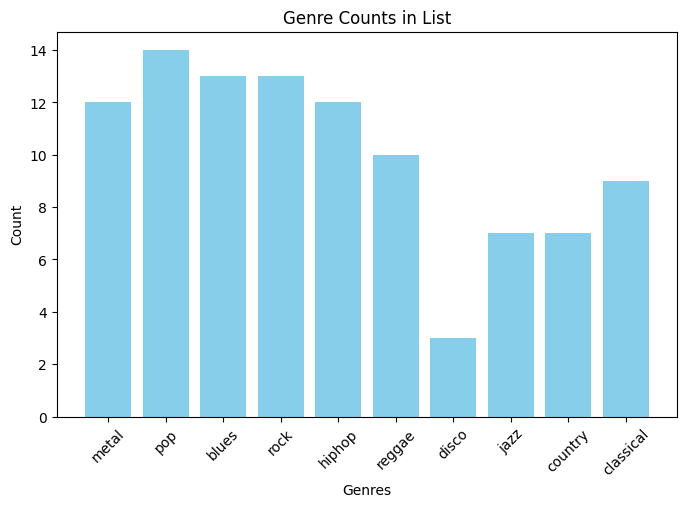

In [12]:
val_genres = []

for sample in df['validation']:
    genre_label = id2label_function(sample['genre'])
    val_genres.append(genre_label)

genre_counts = Counter(val_genres)
labels, values = zip(*genre_counts.items())

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='skyblue')
plt.xlabel("Genres")
plt.ylabel("Count")
plt.title("Genre Counts in List")
plt.xticks(rotation=45)
plt.show()

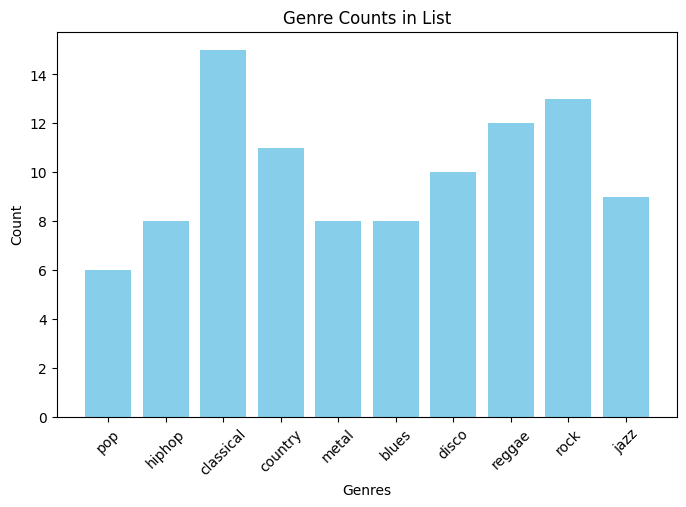

In [13]:
test_genres = []

for sample in df['test']:
    genre_label = id2label_function(sample['genre'])
    test_genres.append(genre_label)

genre_counts = Counter(test_genres)
labels, values = zip(*genre_counts.items())

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='skyblue')
plt.xlabel("Genres")
plt.ylabel("Count")
plt.title("Genre Counts in List")
plt.xticks(rotation=45)
plt.show()

In [14]:
sampling_rate_check = None
all_same = True

# Iterating through each sample
for set_name in ['train', 'test']: # Iterating through both sets
    for sample in df[set_name]:
        sampling_rate = sample['audio']['sampling_rate']

        if sampling_rate_check is None:
            sampling_rate_check = sampling_rate
        else:
            if sampling_rate != sampling_rate_check:
                all_same = False
            break

# Printing result
if all_same:
    print(f"All samples have the same sampling rate: {sampling_rate_check} Hz")
else:
    print("The samples in the dataframe have different sampling rates.")

All samples have the same sampling rate: 22050 Hz


In [15]:
paper_color = '#f5f7f6'
bg_color = '#f5f7f6'
colormap = 'cividis'
labels = {} # Initializing empty list

# Defining a function to count labels
def count_genres(df):
    for sample in df:
        genre_label = id2label_function(sample['genre'])

        if genre_label in labels:
            labels[genre_label] += 1

        else:
            labels[genre_label] = 1

# Counting labels in both sets
count_genres(df['train'])
count_genres(df['validation'])
count_genres(df['test'])

# Obtaining genres and count values
genres = list(labels.keys())
counts = list(labels.values())

# Plotting bar plot
fig = px.bar(x = genres, y = counts, text = counts)
fig.update_traces(marker=dict(color="#4682B4"))
fig.update_layout(title = '<b>Genre Counts</b>', showlegend = True, height = 500, width = 750,
                 plot_bgcolor=bg_color,paper_bgcolor=paper_color)
fig.update_yaxes(title_text = '<b>Count</b>')
fig.update_xaxes(title = '<b>Genres</b>')

fig.show()

In [16]:
from collections import defaultdict
genre_indexes = defaultdict(list)
for index, genre in enumerate(train_genres):
        genre_indexes[genre].append(index)


### Listen and display amplitude

In [17]:
for i in range(df['train'].shape[0]):
  print(i, id2label_function(df['train'][i]['genre']))

0 rock
1 disco
2 disco
3 country
4 jazz
5 classical
6 classical
7 blues
8 disco
9 disco
10 country
11 blues
12 disco
13 classical
14 reggae
15 blues
16 reggae
17 reggae
18 hiphop
19 classical
20 classical
21 rock
22 hiphop
23 disco
24 hiphop
25 country
26 jazz
27 blues
28 country
29 disco
30 reggae
31 disco
32 pop
33 country
34 jazz
35 reggae
36 pop
37 disco
38 disco
39 reggae
40 country
41 disco
42 rock
43 classical
44 country
45 disco
46 hiphop
47 metal
48 country
49 pop
50 hiphop
51 reggae
52 classical
53 metal
54 blues
55 jazz
56 metal
57 reggae
58 country
59 disco
60 classical
61 metal
62 rock
63 disco
64 metal
65 metal
66 jazz
67 reggae
68 pop
69 jazz
70 metal
71 jazz
72 hiphop
73 jazz
74 pop
75 blues
76 metal
77 classical
78 blues
79 pop
80 pop
81 jazz
82 jazz
83 jazz
84 rock
85 jazz
86 country
87 reggae
88 classical
89 blues
90 hiphop
91 blues
92 rock
93 rock
94 jazz
95 disco
96 metal
97 blues
98 disco
99 country
100 reggae
101 pop
102 classical
103 country
104 reggae
105 metal

ids:
*   id = 2 -> disco
*   id = 3 -> country
*   id = 4 -> jazz
*   id = 5 -> classical
*   id = 7 -> blues
*   id = 14 -> raggae
*   id = 18 -> hiphop
*   id = 42 -> rock
*   id = 32 -> pop
*   id = 212 -> metal



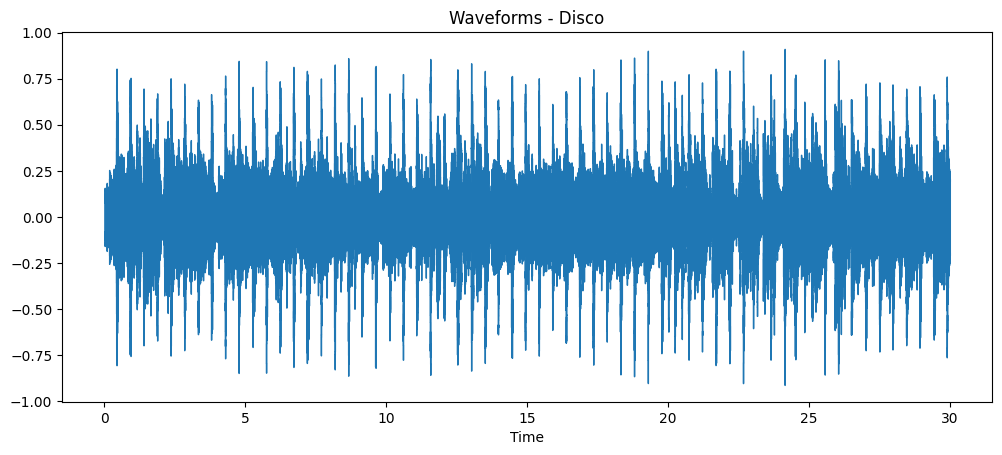

genre:  disco


In [18]:
id = 2
# Selecting array sound & sampling rate
array = df['train'][id]['audio']['array']
sampling_rate = df['train'][id]['audio']['sampling_rate']

# Plotting waveform with librosa
plt.figure().set_figwidth(12)
plt.title('Waveforms - Disco')
librosa.display.waveshow(array, sr = sampling_rate)
plt.show()

# Printing genre
print("genre: ", id2label_function(df['train'][id]['genre']))

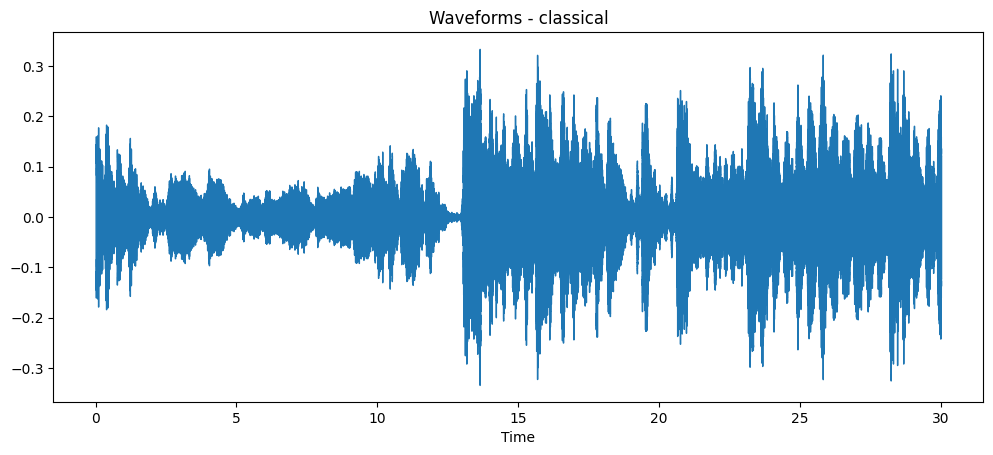

genre:  classical


In [19]:
id = 5
# Selecting array sound & sampling rate
array = df['train'][id]['audio']['array']
sampling_rate = df['train'][id]['audio']['sampling_rate']

# Plotting waveform with librosa
plt.figure().set_figwidth(12)
plt.title('Waveforms - classical')
librosa.display.waveshow(array, sr = sampling_rate)
plt.show()

# Printing genre
print("genre: ", id2label_function(df['train'][id]['genre']))

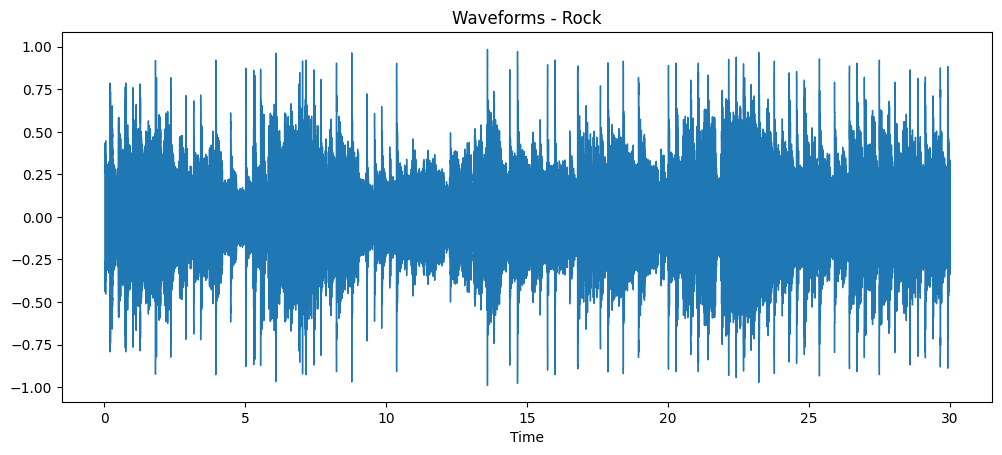

genre:  rock


In [20]:
id = 797
# Selecting array sound & sampling rate
array = df['train'][id]['audio']['array']
sampling_rate = df['train'][id]['audio']['sampling_rate']

# Plotting waveform with librosa
plt.figure().set_figwidth(12)
plt.title('Waveforms - Rock')
librosa.display.waveshow(array, sr = sampling_rate)
plt.show()

# Printing genre
print("genre: ", id2label_function(df['train'][id]['genre']))

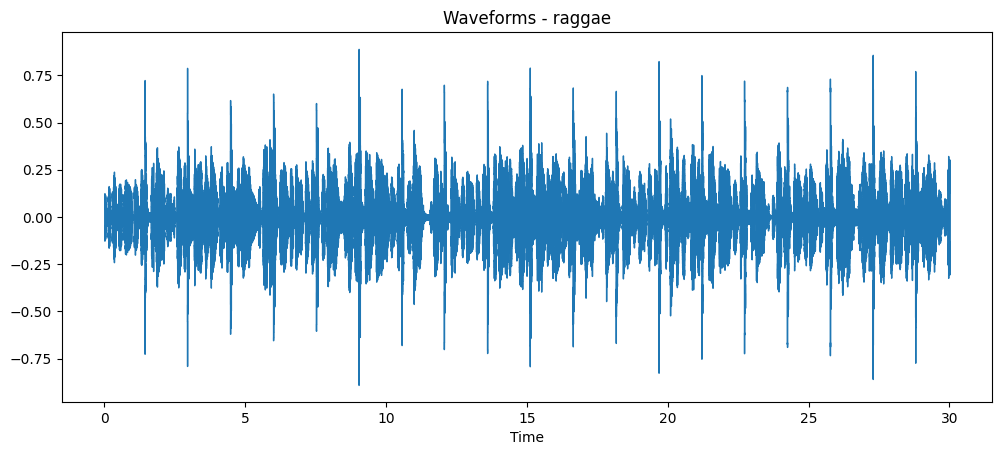

genre:  reggae


In [21]:
id = 14
# Selecting array sound & sampling rate
array = df['train'][id]['audio']['array']
sampling_rate = df['train'][id]['audio']['sampling_rate']

# Plotting waveform with librosa
plt.figure().set_figwidth(12)
plt.title('Waveforms - raggae')
librosa.display.waveshow(array, sr = sampling_rate)
plt.show()

# Printing genre
print("genre: ", id2label_function(df['train'][id]['genre']))

# Spectrograms

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

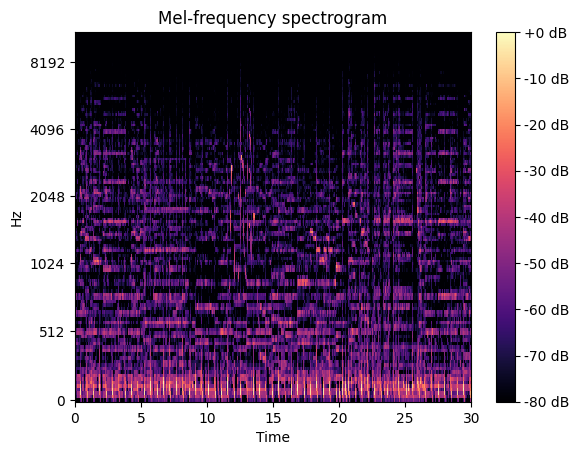

In [22]:
id = 2
array = df['train'][id]['audio']['array']

S = librosa.feature.melspectrogram(y=array, sr=22050)

fig, ax = plt.subplots()
S_dB = librosa.amplitude_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=22050,
                        ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

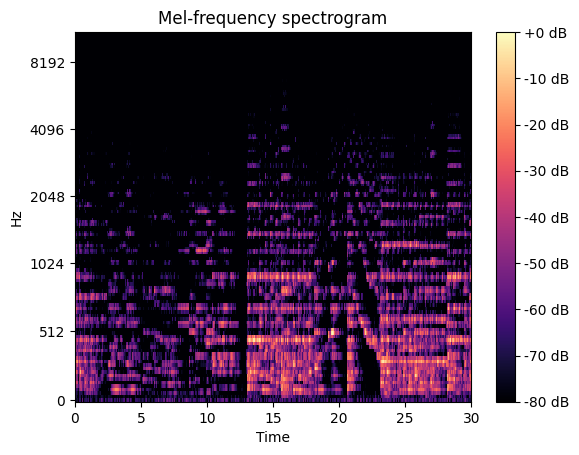

In [23]:
id = 5
array = df['train'][id]['audio']['array']

S = librosa.feature.melspectrogram(y=array, sr=22050)

fig, ax = plt.subplots()
S_dB = librosa.amplitude_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=22050,
                        ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

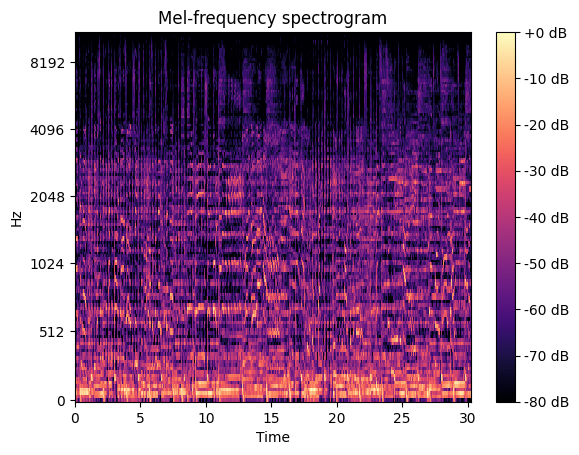

In [24]:
id = 42
array = df['train'][id]['audio']['array']

S = librosa.feature.melspectrogram(y=array, sr=22050)

fig, ax = plt.subplots()
S_dB = librosa.amplitude_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=22050,
                        ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

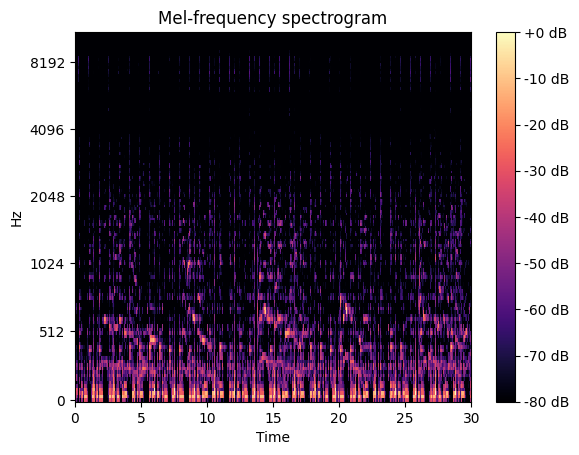

In [25]:
id = 14
array = df['train'][id]['audio']['array']

S = librosa.feature.melspectrogram(y=array, sr=22050)

fig, ax = plt.subplots()
S_dB = librosa.amplitude_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=22050,
                        ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

# Data Augmentation

In [26]:
def split_audio(audio_array):

    split_coef = len(audio_array) // 6
    first = audio_array[:split_coef]
    second = audio_array[split_coef:split_coef*2]
    third = audio_array[split_coef*2:split_coef*3]
    fourth = audio_array[split_coef*2:split_coef*3]
    fith = audio_array[split_coef*2:split_coef*3]
    sixth = audio_array[split_coef*2:split_coef*3]

    return first, second, third, fourth, fith, sixth

In [27]:
train_dict = {}
validation_dict = {}
test_dict = {}

for i, item in enumerate(df['train']):
    train_dict[i] = item

for i, item in enumerate(df['test']):
    test_dict[i] = item

for i, item in enumerate(df['validation']):
    validation_dict[i] = item

train_dict[0]

{'file': '/root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/rock/rock.00012.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/rock/rock.00012.wav',
  'array': array([-0.006073  ,  0.0144043 ,  0.04669189, ..., -0.00701904,
         -0.01977539, -0.02853394]),
  'sampling_rate': 22050},
 'genre': 9}

In [28]:
length = len(train_dict)

for id in range(length):
    instance = train_dict[id]

    audio = instance['audio']['array']
    genre = instance['genre']

    p1,p2,p3,p4,p5,p6 = split_audio(audio)

    inst = {'file':'none', 'audio':{'path':'none','array': np.array(p1), 'sampling_rate':22050}, 'genre':genre}
    inst1 = {'file':'none','audio':{'path':'none', 'array':np.array(p2), 'sampling_rate':22050}, 'genre':genre}
    inst2 = {'file':'none', 'audio':{'path':'none','array': np.array(p3), 'sampling_rate':22050}, 'genre':genre}
    inst3 = {'file':'none', 'audio':{'path':'none','array': np.array(p4), 'sampling_rate':22050}, 'genre':genre}
    inst4 = {'file':'none','audio':{'path':'none', 'array':np.array(p5), 'sampling_rate':22050}, 'genre':genre}
    inst5 = {'file':'none', 'audio':{'path':'none','array': np.array(p6), 'sampling_rate':22050}, 'genre':genre}

    train_dict[length] = inst
    train_dict[length+1] = inst1
    train_dict[length+2] = inst2
    train_dict[length+3] = inst3
    train_dict[length+4] = inst4
    train_dict[length+5] = inst5

    length += 6



In [29]:
length = len(validation_dict)

for id in range(length):
    instance = validation_dict[id]

    audio = instance['audio']['array']
    genre = instance['genre']

    p1,p2,p3,p4,p5,p6 = split_audio(audio)

    inst = {'file':'none', 'audio':{'path':'none','array': np.array(p1), 'sampling_rate':22050}, 'genre':genre}
    inst1 = {'file':'none','audio':{'path':'none', 'array':np.array(p2), 'sampling_rate':22050}, 'genre':genre}
    inst2 = {'file':'none', 'audio':{'path':'none','array': np.array(p3), 'sampling_rate':22050}, 'genre':genre}
    inst3 = {'file':'none', 'audio':{'path':'none','array': np.array(p4), 'sampling_rate':22050}, 'genre':genre}
    inst4 = {'file':'none','audio':{'path':'none', 'array':np.array(p5), 'sampling_rate':22050}, 'genre':genre}
    inst5 = {'file':'none', 'audio':{'path':'none','array': np.array(p6), 'sampling_rate':22050}, 'genre':genre}

    validation_dict[length] = inst
    validation_dict[length+1] = inst1
    validation_dict[length+2] = inst2
    validation_dict[length+3] = inst3
    validation_dict[length+4] = inst4
    validation_dict[length+5] = inst5

    length += 6

# Feature extraction

In [30]:
def normalize(feature_list):
  eps = 0.001

  mean = np.mean(feature_list)
  sd = np.std(feature_list)

  tmp = (feature_list - mean + eps)/(sd + eps)
  return tmp

In [31]:

def energy_feat(input):
    return np.sum((input*1.0)**2, keepdims=True)

def compute_mfcc(audio_arrays, sampling_rate, n_mfcc=40):

    mfcc_results = [librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=n_mfcc) for audio in audio_arrays]

    delta1_list = []
    delta2_list = []
    for m in mfcc_results:
       delta_1 = librosa.feature.delta(m, order=1)
       delta_2 = librosa.feature.delta(m, order=2)
       delta1_list.append(delta_1)
       delta2_list.append(delta_2)

    return mfcc_results, delta1_list, delta2_list

def compute_features(audio):
    features = []

    tempo = librosa.feature.tempo(y = audio)
    spectral_centroid = librosa.feature.spectral_centroid(y = audio, sr=22050)[0][:1293]
    zcr = librosa.feature.zero_crossing_rate(y=audio)[0][:1293]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=22050)[0][:1293]
    rollof = librosa.feature.spectral_rolloff(y=audio, sr=22050, roll_percent=0.90)[0][:1293]
    energy = energy_feat(audio)

    spectral_bandwidth = np.concatenate((spectral_bandwidth, np.zeros(1293-spectral_bandwidth.shape[0])))
    spectral_centroid = np.concatenate((spectral_centroid, np.zeros(1293-spectral_centroid.shape[0])))
    rollof = np.concatenate((rollof, np.zeros(1293-rollof.shape[0])))
    zcr = np.concatenate((zcr, np.zeros(1293-zcr.shape[0])))


    features.append(tempo)
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(rollof)
    features.append(zcr)
    features.append(energy)

    return features


In [32]:
ground_truth_train = [train_dict[id]['genre'] for id in range(len(train_dict))]
ground_truth_validation = [validation_dict[id]['genre'] for id in range(len(validation_dict))]
ground_truth_test = [test_dict[id]['genre'] for id in range(len(test_dict))]

train = [train_dict[id]['audio']['array'] for id in range(len(train_dict))]
validation = [validation_dict[id]['audio']['array'] for id in range(len(validation_dict))]
test = [test_dict[id]['audio']['array'] for id in range(len(test_dict))]

In [33]:
len(ground_truth_train), len(train)

(5593, 5593)

In [34]:
mfcc_train, delta1_train, delta2_train = compute_mfcc(train, sampling_rate)
mfcc_validation, delta1_val, delta2_val = compute_mfcc(validation, sampling_rate)
mfcc_test, delta1_test, delta2_test = compute_mfcc(test, sampling_rate)

print(f"MFCC Train shape: {delta1_train[0].shape}")
print(f"MFCC Validation shape: {mfcc_validation[0].shape}")
print(f"MFCC Test shape: {mfcc_test[0].shape}")

MFCC Train shape: (40, 1293)
MFCC Validation shape: (40, 1293)
MFCC Test shape: (40, 1293)


In [35]:
def cut_mfcc(mfcc_results, target_n_frames=1284):

    mfcc_cut_results = []

    for mfcc in mfcc_results:
        # Seleziona solo i primi 1293 frame
        mfcc = mfcc[:, :target_n_frames]

        # Se la matrice ha meno di 1293 frame, aggiungi padding con zeri
        if mfcc.shape[1] < target_n_frames:
            padding = np.zeros((mfcc.shape[0], target_n_frames - mfcc.shape[1]))
            mfcc = np.hstack([mfcc, padding])

        # Aggiungi la matrice MFCC tagliata alla lista dei risultati
        mfcc_cut_results.append(mfcc)

    return mfcc_cut_results


mfcc_train_cut = cut_mfcc(mfcc_train)
mfcc_validation_cut = cut_mfcc(mfcc_validation)
mfcc_test_cut = cut_mfcc(mfcc_test)

print(f"MFCC Train Cut shape: {mfcc_train_cut[0].shape}")
print(f"MFCC Validation Cut shape: {mfcc_validation_cut[0].shape}")
print(f"MFCC Test Cut shape: {mfcc_test_cut[0].shape}")

MFCC Train Cut shape: (40, 1284)
MFCC Validation Cut shape: (40, 1284)
MFCC Test Cut shape: (40, 1284)


In [36]:
def mfcc_feat(mfccs):

    features = []

    for m in mfccs:
        mfcc_feat = np.mean(m.T,axis=0)
        features.append(mfcc_feat)

    return features

mfcc_train_feat = mfcc_feat(mfcc_train)
mfcc_validation_feat = mfcc_feat(mfcc_validation)
mfcc_test_feat = mfcc_feat(mfcc_test)

d1_train_feat = mfcc_feat(delta1_train)
d1_validation_feat = mfcc_feat(delta1_val)
d1_test_feat = mfcc_feat(delta1_test)

d2_train_feat = mfcc_feat(delta2_train)
d2_validation_feat = mfcc_feat(delta2_val)
d2_test_feat = mfcc_feat(delta2_test)

len(d2_train_feat), mfcc_train_feat[0].shape

(5593, (40,))

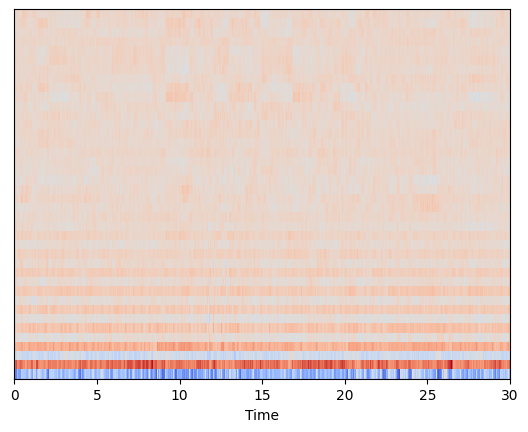

In [37]:
librosa.display.specshow(mfcc_train[2], x_axis='time')

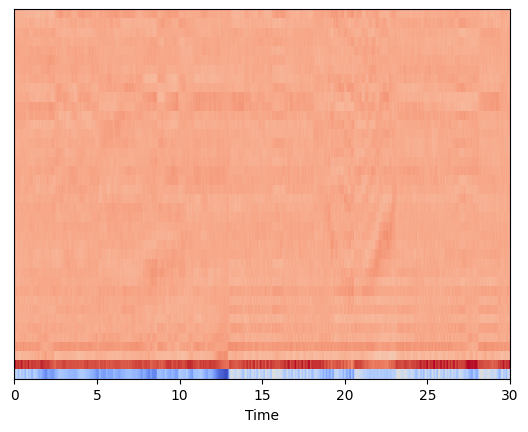

In [38]:
librosa.display.specshow(mfcc_train[5], x_axis='time')

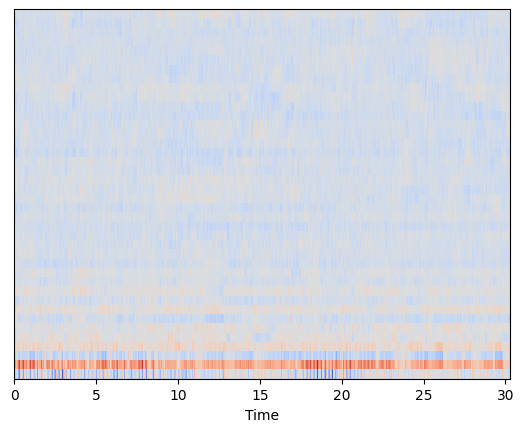

In [39]:
librosa.display.specshow(mfcc_train[42], x_axis='time')

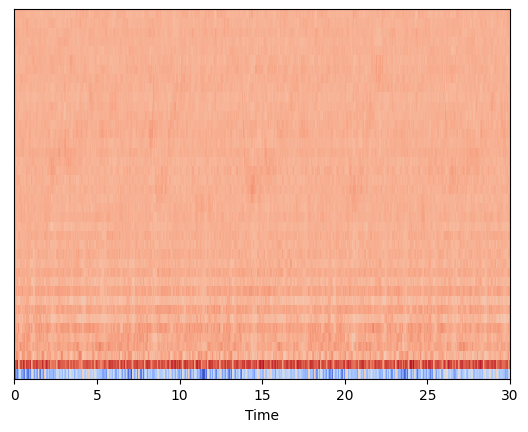

In [40]:
librosa.display.specshow(mfcc_train[14], x_axis='time')

In [41]:
train_features = [compute_features(x) for x in train]
test_features = [compute_features(x) for x in test]
validation_features = [compute_features(x) for x in validation]

In [42]:
train_features_full = []
for i in range(len(train)):
    mfcc = mfcc_train_feat[i]
    feats = train_features[i]
    #mfcc = np.append(mfcc, feats[0][0])
    #mfcc = np.append(mfcc, np.mean(feats[1]))
    #mfcc = np.append(mfcc, np.mean(feats[2]))
    #mfcc = np.append(mfcc, np.mean(feats[3]))
    #mfcc = np.append(mfcc, np.mean(feats[4]))
    #mfcc = np.append(mfcc, feats[5])
    train_features_full.append(mfcc)

train_features_full = np.array(train_features_full)
#np.mean(feats[][0])
validation_features_full = []
for i in range(len(validation)):
    mfcc = mfcc_validation_feat[i]
    feats = validation_features[i]
    #mfcc = np.append(mfcc, feats[0][0])
    #mfcc = np.append(mfcc, np.mean(feats[1]))
    #mfcc = np.append(mfcc, np.mean(feats[2]))
    #mfcc = np.append(mfcc, np.mean(feats[3]))
    #mfcc = np.append(mfcc, np.mean(feats[4]))
    #mfcc = np.append(mfcc, feats[5])
    validation_features_full.append(mfcc)

validation_features_full = np.array(validation_features_full)

test_features_full = []
for i in range(len(test)):
    mfcc = mfcc_test_feat[i]
    feats = test_features[i]
    #mfcc = np.append(mfcc, feats[0][0])
    #mfcc = np.append(mfcc, np.mean(feats[1]))
    #mfcc = np.append(mfcc, np.mean(feats[2]))
    #mfcc = np.append(mfcc, np.mean(feats[3]))
    #mfcc = np.append(mfcc, np.mean(feats[4]))
    #mfcc = np.append(mfcc, feats[5])
    test_features_full.append(mfcc)

test_features_full = np.array(test_features_full)

In [43]:
train_features_full.shape

(5593, 40)

In [44]:
train_features_full = np.array([normalize(x) for x in train_features_full])
validation_features_full = np.array([normalize(x) for x in validation_features_full])
test_features_full = np.array([normalize(x) for x in test_features_full])

# Baseline models


Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.38      0.43         8
           1       0.83      1.00      0.91        15
           2       0.50      0.45      0.48        11
           3       0.44      0.70      0.54        10
           4       0.67      0.50      0.57         8
           5       0.36      0.44      0.40         9
           6       0.58      0.88      0.70         8
           7       0.80      0.67      0.73         6
           8       0.54      0.58      0.56        12
           9       1.00      0.23      0.38        13

    accuracy                           0.59       100
   macro avg       0.62      0.58      0.57       100
weighted avg       0.64      0.59      0.57       100



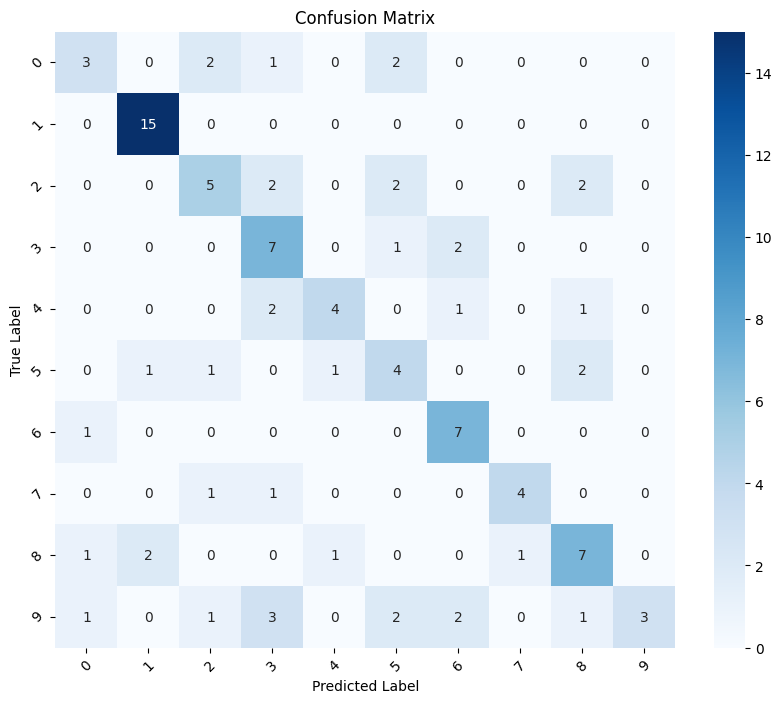

In [45]:
svc = SVC(kernel="rbf", C=1.0, gamma="scale")
svc.fit(train_features_full, ground_truth_train)

y_pred = svc.predict(test_features_full)

print("\nClassification Report:\n", classification_report(ground_truth_test, y_pred))

cm = confusion_matrix(ground_truth_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.83      1.00      0.91        15
           2       0.42      0.45      0.43        11
           3       0.67      0.60      0.63        10
           4       0.56      0.62      0.59         8
           5       0.18      0.22      0.20         9
           6       0.67      1.00      0.80         8
           7       0.62      0.83      0.71         6
           8       0.50      0.42      0.45        12
           9       0.67      0.31      0.42        13

    accuracy                           0.60       100
   macro avg       0.61      0.61      0.59       100
weighted avg       0.62      0.60      0.59       100



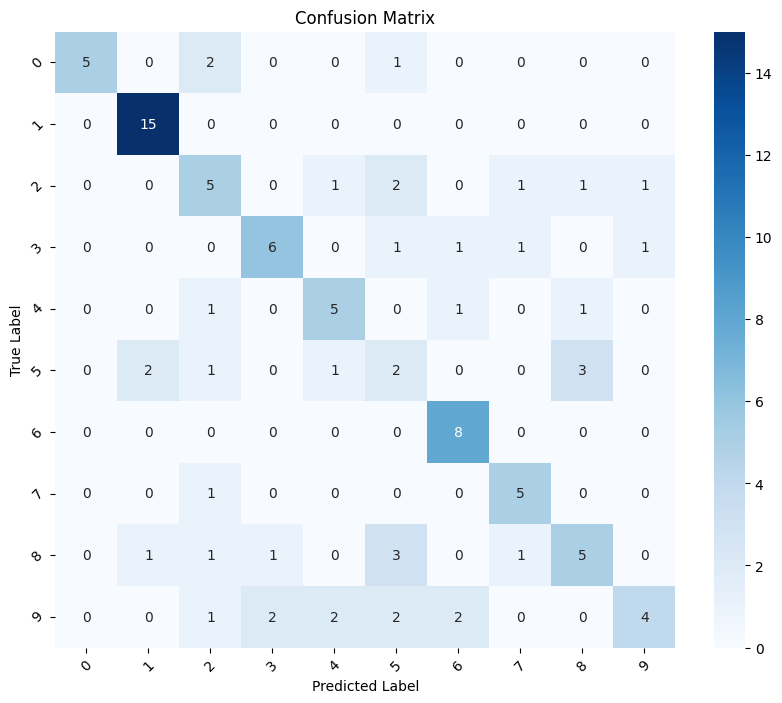

In [46]:

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(train_features_full, ground_truth_train)

y_pred = rf.predict(test_features_full)

print("\nClassification Report:\n", classification_report(ground_truth_test, y_pred))

cm = confusion_matrix(ground_truth_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# DL models

In [47]:
def plot_history(history):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylim([0.0, 3.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'validation'])

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.ylim([0, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'validation'])

In [48]:
X_train = np.array(train_features_full)  # Matrici MFCC per il training
X_validation = np.array(validation_features_full)  # Matrici MFCC per la validazione
X_test = np.array(test_features_full)  # Matrici MFCC per il test

y_train = np.array(ground_truth_train)  # Etichette del training
y_validation = np.array(ground_truth_validation)  # Etichette della validazione
y_test = np.array(ground_truth_test)  # Etichette del test

# Definisci il numero di classi
n_classes = len(np.unique(y_train))  # Numero di generi distinti

id2label_function = df['train'].features['genre'].int2str

# Trova tutti i generi unici nel dataset
unique_genre_ids = sorted(set(ground_truth_train + ground_truth_validation + ground_truth_test))
num_classes = len(unique_genre_ids)

# Mappatura ID -> Nome del genere
genre_mapping = {genre_id: id2label_function(genre_id) for genre_id in unique_genre_ids}

y_train = to_categorical([unique_genre_ids.index(g) for g in ground_truth_train], num_classes=num_classes)
y_validation = to_categorical([unique_genre_ids.index(g) for g in ground_truth_validation], num_classes=num_classes)
y_test = to_categorical([unique_genre_ids.index(g) for g in ground_truth_test], num_classes=num_classes)
y_train = y_train
# Definizione della rete neurale
model = Sequential([
    Input(shape=(40,)),

    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),

    Dense(num_classes, activation='softmax')
])

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='weights/FFNN_MFCC.weights.h5',
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    checkpoint_callback
]

# Addestramento con validazione
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=20, batch_size=32, callbacks=callbacks)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1925 - loss: 2.5144
Epoch 1: val_accuracy improved from -inf to 0.43143, saving model to weights/FFNN_MFCC.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.1928 - loss: 2.5130 - val_accuracy: 0.4314 - val_loss: 1.7899 - learning_rate: 0.0010
Epoch 2/20
170/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3512 - loss: 1.8703
Epoch 2: val_accuracy improved from 0.43143 to 0.48571, saving model to weights/FFNN_MFCC.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3516 - loss: 1.8682 - val_accuracy: 0.4857 - val_loss: 1.5517 - learning_rate: 0.0010
Epoch 3/20
168/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4054 - loss: 1.6945
Epoch 3: val_accuracy improved from 0.48571 to 0.48714, saving model to weights/FFNN_MFCC.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4063 - loss: 1.6920 - val_accuracy: 0.4871 - val_loss: 1.4444 - learning_rate: 0.0010
Epoch 4/20
165/17

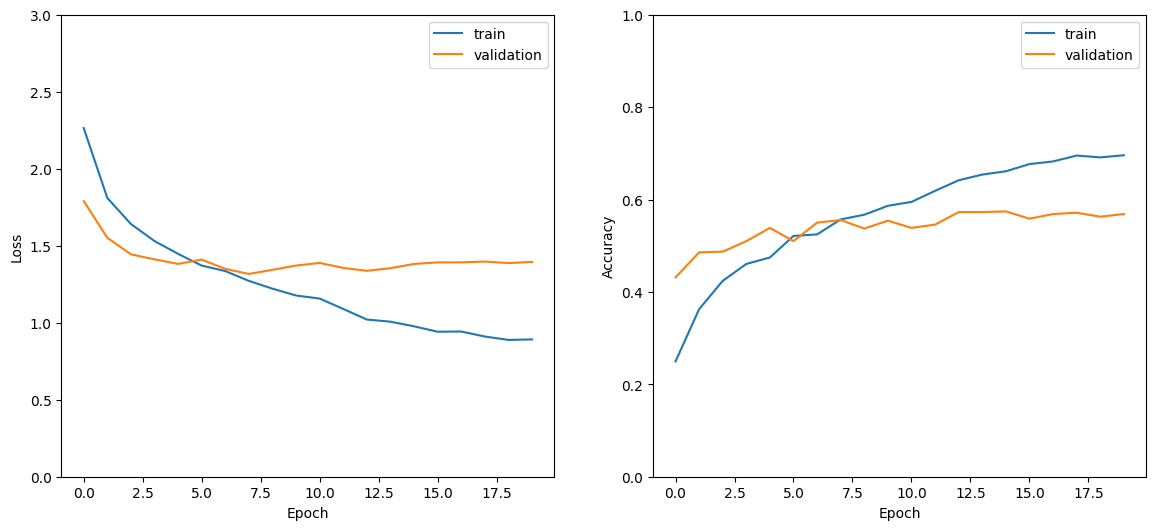

In [49]:
plot_history(history.history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


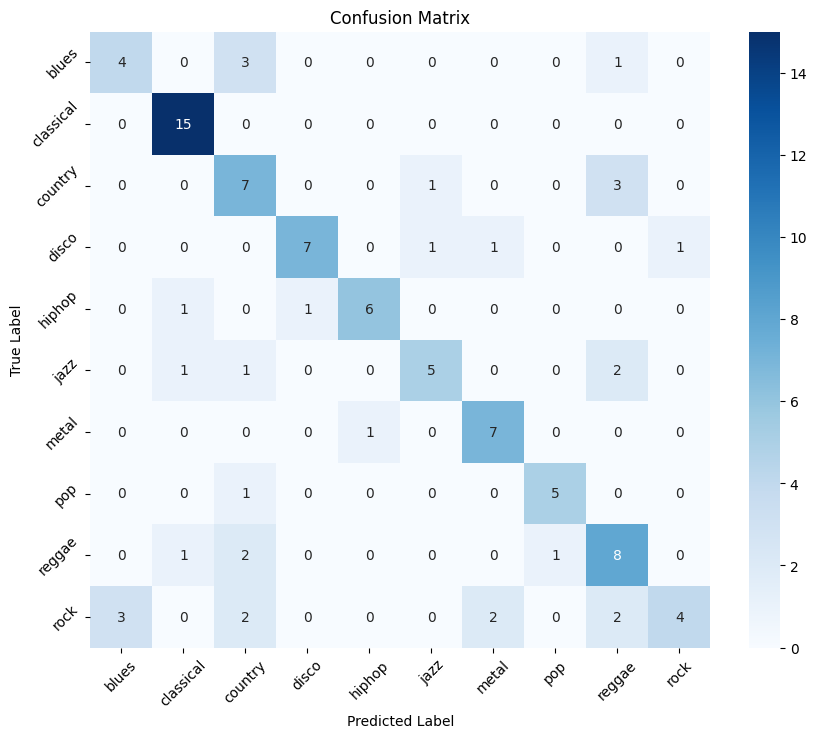


Classification Report:
              precision    recall  f1-score   support

       blues       0.57      0.50      0.53         8
   classical       0.83      1.00      0.91        15
     country       0.44      0.64      0.52        11
       disco       0.88      0.70      0.78        10
      hiphop       0.86      0.75      0.80         8
        jazz       0.71      0.56      0.62         9
       metal       0.70      0.88      0.78         8
         pop       0.83      0.83      0.83         6
      reggae       0.50      0.67      0.57        12
        rock       0.80      0.31      0.44        13

    accuracy                           0.68       100
   macro avg       0.71      0.68      0.68       100
weighted avg       0.71      0.68      0.67       100



In [50]:
model.load_weights('weights/FFNN_MFCC.weights.h5')
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converti one-hot in classi
y_test_classes = np.argmax(y_test, axis=1)  # Converti one-hot in classi

# Genera la confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Etichette dei generi per asse x/y
genre_labels = [genre_mapping[g] for g in unique_genre_ids]

# Plot della Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=genre_labels, yticklabels=genre_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Report di classificazione
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=genre_labels))

# Other fetures more than MFCC

In [51]:
train_features_full = []
for i in range(len(train)):
    mfcc = mfcc_train_feat[i]
    feats = train_features[i]
    mfcc = np.append(mfcc, feats[0][0])
    #mfcc = np.append(mfcc, np.mean(feats[1]))
    #mfcc = np.append(mfcc, np.mean(feats[2]))
    mfcc = np.append(mfcc, np.mean(feats[4]))
    #mfcc = np.append(mfcc, feats[5])
    train_features_full.append(mfcc)

train_features_full = np.array(train_features_full)
#np.mean(feats[][0])
validation_features_full = []
for i in range(len(validation)):
    mfcc = mfcc_validation_feat[i]
    feats = validation_features[i]
    mfcc = np.append(mfcc, feats[0][0])
    #mfcc = np.append(mfcc, np.mean(feats[1]))
    #mfcc = np.append(mfcc, np.mean(feats[2]))
    mfcc = np.append(mfcc, np.mean(feats[4]))
    #mfcc = np.append(mfcc, feats[5])
    validation_features_full.append(mfcc)

validation_features_full = np.array(validation_features_full)

test_features_full = []
for i in range(len(test)):
    mfcc = mfcc_test_feat[i]
    feats = test_features[i]
    mfcc = np.append(mfcc, feats[0][0])
    #mfcc = np.append(mfcc, np.mean(feats[1]))
    #mfcc = np.append(mfcc, np.mean(feats[2]))
    mfcc = np.append(mfcc, np.mean(feats[4]))
    #mfcc = np.append(mfcc, feats[5])
    test_features_full.append(mfcc)

test_features_full = np.array(test_features_full)

In [52]:
train_features_full = np.array([normalize(x) for x in train_features_full])
validation_features_full = np.array([normalize(x) for x in validation_features_full])
test_features_full = np.array([normalize(x) for x in test_features_full])

# baseline


Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.62      0.45         8
           1       0.79      1.00      0.88        15
           2       0.36      0.36      0.36        11
           3       0.60      0.60      0.60        10
           4       0.60      0.38      0.46         8
           5       0.33      0.22      0.27         9
           6       0.60      0.75      0.67         8
           7       0.83      0.83      0.83         6
           8       0.38      0.50      0.43        12
           9       0.33      0.08      0.12        13

    accuracy                           0.53       100
   macro avg       0.52      0.53      0.51       100
weighted avg       0.51      0.53      0.50       100



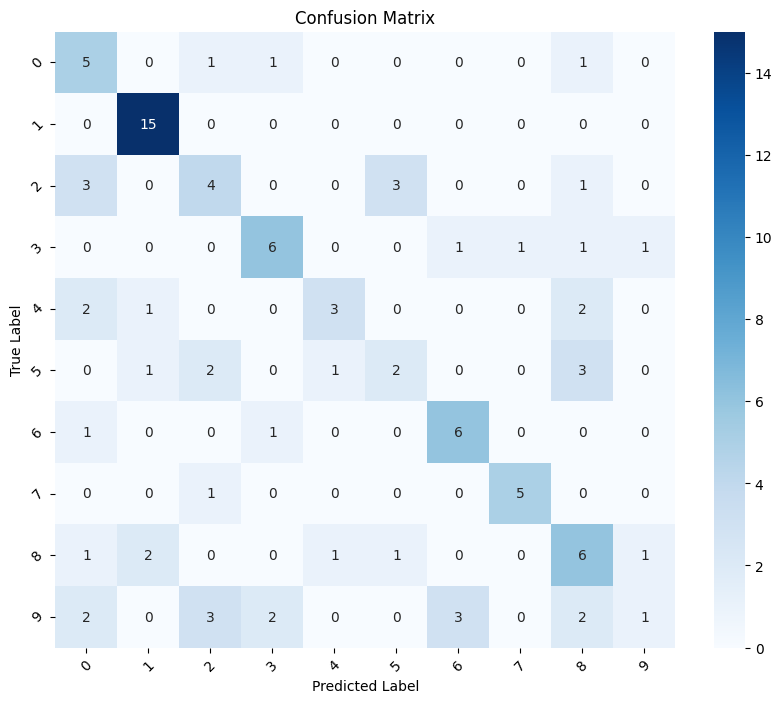

In [53]:
svc = SVC(kernel="rbf", C=1.0, gamma="scale")
svc.fit(train_features_full, ground_truth_train)

y_pred = svc.predict(test_features_full)

print("\nClassification Report:\n", classification_report(ground_truth_test, y_pred))

cm = confusion_matrix(ground_truth_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.83      1.00      0.91        15
           2       0.45      0.45      0.45        11
           3       0.78      0.70      0.74        10
           4       0.62      0.62      0.62         8
           5       0.25      0.22      0.24         9
           6       0.67      1.00      0.80         8
           7       0.75      1.00      0.86         6
           8       0.56      0.75      0.64        12
           9       0.80      0.31      0.44        13

    accuracy                           0.65       100
   macro avg       0.65      0.66      0.63       100
weighted avg       0.66      0.65      0.63       100



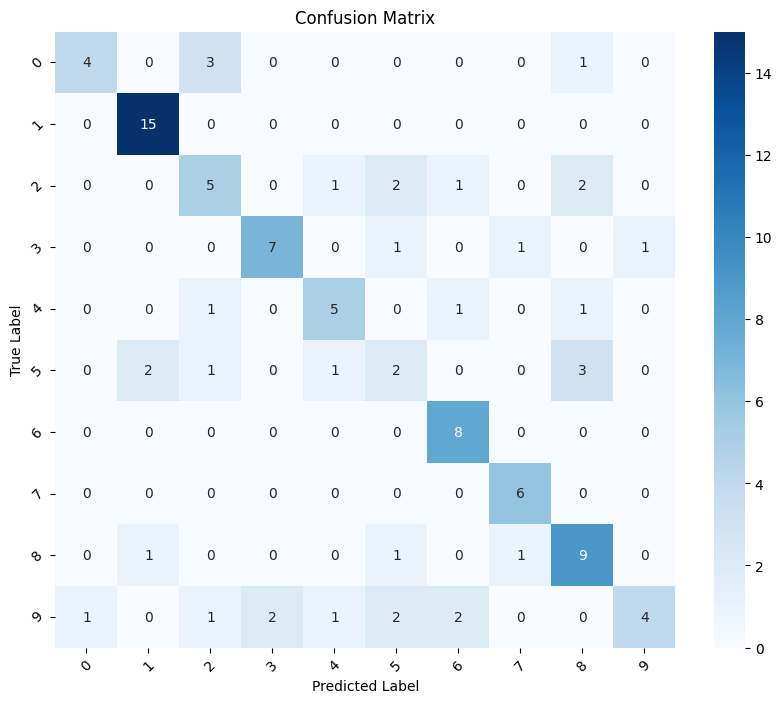

In [54]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(train_features_full, ground_truth_train)

y_pred = rf.predict(test_features_full)

print("\nClassification Report:\n", classification_report(ground_truth_test, y_pred))

cm = confusion_matrix(ground_truth_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Deep Learning

In [55]:
X_train = np.array(train_features_full)  # Matrici MFCC per il training
X_validation = np.array(validation_features_full)  # Matrici MFCC per la validazione
X_test = np.array(test_features_full)  # Matrici MFCC per il test

y_train = np.array(ground_truth_train)  # Etichette del training
y_validation = np.array(ground_truth_validation)  # Etichette della validazione
y_test = np.array(ground_truth_test)  # Etichette del test

# Definisci il numero di classi
n_classes = len(np.unique(y_train))  # Numero di generi distinti

id2label_function = df['train'].features['genre'].int2str

# Trova tutti i generi unici nel dataset
unique_genre_ids = sorted(set(ground_truth_train + ground_truth_validation + ground_truth_test))
num_classes = len(unique_genre_ids)

# Mappatura ID -> Nome del genere
genre_mapping = {genre_id: id2label_function(genre_id) for genre_id in unique_genre_ids}

y_train = to_categorical([unique_genre_ids.index(g) for g in ground_truth_train], num_classes=num_classes)
y_validation = to_categorical([unique_genre_ids.index(g) for g in ground_truth_validation], num_classes=num_classes)
y_test = to_categorical([unique_genre_ids.index(g) for g in ground_truth_test], num_classes=num_classes)
y_train = y_train

model = Sequential([
    Input(shape=(42,)),

    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),


    Dense(num_classes, activation='softmax')
])

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='weights/FFNN_Fullfeatures.weights.h5',
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    checkpoint_callback
]

# Addestramento con validazione
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=20, batch_size=32, callbacks=callbacks)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2256 - loss: 2.4084
Epoch 1: val_accuracy improved from -inf to 0.40429, saving model to weights/FFNN_Fullfeatures.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2259 - loss: 2.4072 - val_accuracy: 0.4043 - val_loss: 1.7557 - learning_rate: 0.0010
Epoch 2/20
160/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3471 - loss: 1.8831
Epoch 2: val_accuracy improved from 0.40429 to 0.48571, saving model to weights/FFNN_Fullfeatures.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3489 - loss: 1.8766 - val_accuracy: 0.4857 - val_loss: 1.5321 - learning_rate: 0.0010
Epoch 3/20
162/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4095 - loss: 1.6731
Epoch 3: val_accuracy improved from 0.48571 to 0.52857, saving model to weights/FFNN_Fullfeatures.weights.h5
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4106 - loss: 1.6695 - val_accuracy: 0.5286 - val_loss: 1.4203 - learning_rate: 

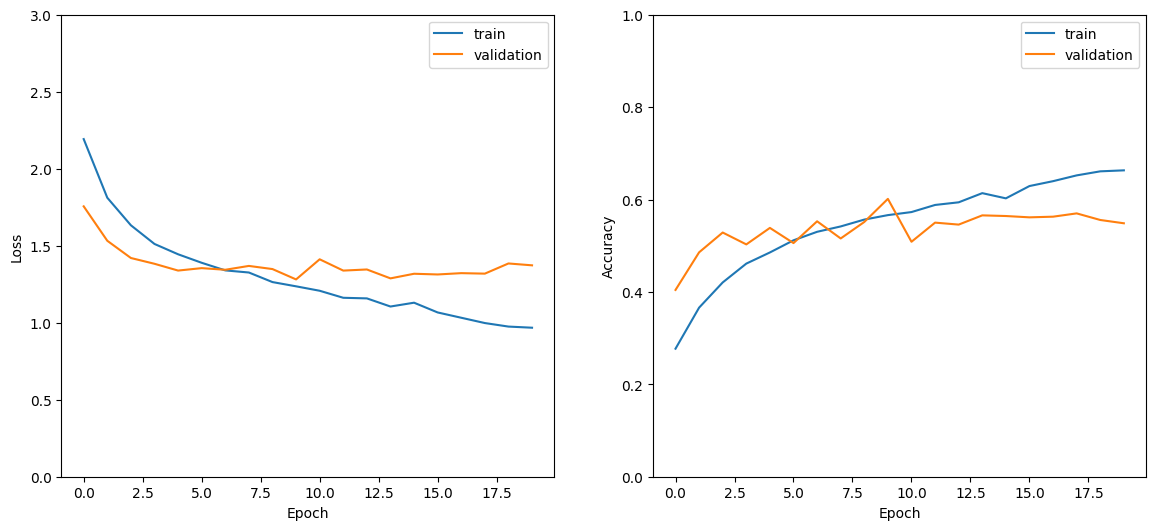

In [56]:
plot_history(history.history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


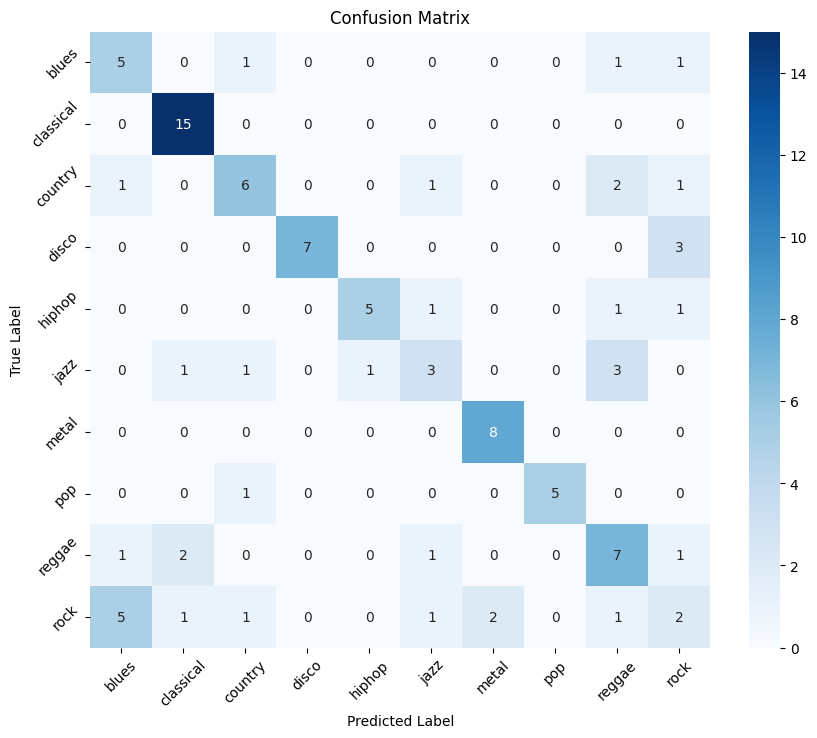


Classification Report:
              precision    recall  f1-score   support

       blues       0.42      0.62      0.50         8
   classical       0.79      1.00      0.88        15
     country       0.60      0.55      0.57        11
       disco       1.00      0.70      0.82        10
      hiphop       0.83      0.62      0.71         8
        jazz       0.43      0.33      0.38         9
       metal       0.80      1.00      0.89         8
         pop       1.00      0.83      0.91         6
      reggae       0.47      0.58      0.52        12
        rock       0.22      0.15      0.18        13

    accuracy                           0.63       100
   macro avg       0.66      0.64      0.64       100
weighted avg       0.63      0.63      0.62       100



In [57]:
model.load_weights('weights/FFNN_Fullfeatures.weights.h5')
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converti one-hot in classi
y_test_classes = np.argmax(y_test, axis=1)  # Converti one-hot in classi

# Genera la confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Etichette dei generi per asse x/y
genre_labels = [genre_mapping[g] for g in unique_genre_ids]

# Plot della Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=genre_labels, yticklabels=genre_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Report di classificazione
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=genre_labels))

# Some results

In [ ]:
X_train = np.array(train_features_full)  # Matrici MFCC per il training
X_validation = np.array(validation_features_full)  # Matrici MFCC per la validazione
X_test = np.array(test_features_full)  # Matrici MFCC per il test

y_train = np.array(ground_truth_train)  # Etichette del training
y_validation = np.array(ground_truth_validation)  # Etichette della validazione
y_test = np.array(ground_truth_test)

In [ ]:
model = Sequential([

    Input(shape=(40,)),

    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),

    Dense(num_classes, activation='softmax')

])

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\gabri\OneDrive\Desktop\progetto DSIM\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Ground truth: 7, predicted 3


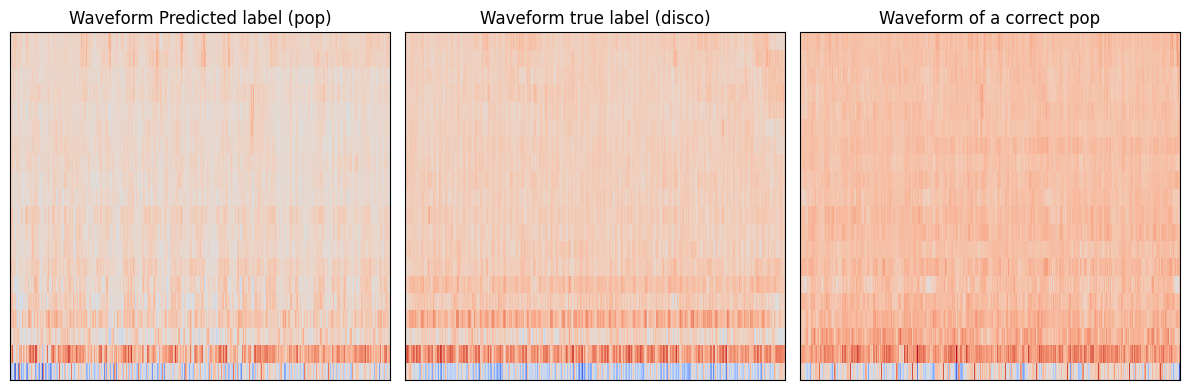

In [ ]:
model.load_weights('weights/FFNN_MFCC.weights.h5')
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converti one-hot in classi
y_test_classes = y_test

correct_indexes = []
wrong_indexes = []

for i in range(y_test_classes.shape[0]):
    if y_pred_classes[i] == y_test_classes[i]:
        correct_indexes.append(i)
    else:
        wrong_indexes.append(i)

w = wrong_indexes[0]
w1 = wrong_indexes[10]
audio = df['test'][w]['audio']['array']
audio1 = df['test'][w1]['audio']['array']

print(f'Ground truth: {y_test_classes[w]}, predicted {y_pred_classes[w]}')
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

librosa.display.specshow(librosa.feature.mfcc(y=audio), sr=sampling_rate, ax=ax[0])
ax[0].set_title("Waveform Predicted label (pop)")

librosa.display.specshow(librosa.feature.mfcc(y=df['train'][9]['audio']['array']), sr=sampling_rate, ax=ax[1])
ax[1].set_title("Waveform true label (disco)")

librosa.display.specshow(librosa.feature.mfcc(y=df['test'][1]['audio']['array']), sr=sampling_rate, ax=ax[2])
ax[2].set_title("Waveform of a correct pop")

plt.tight_layout()
plt.show()



Ground truth: 4, predicted 3


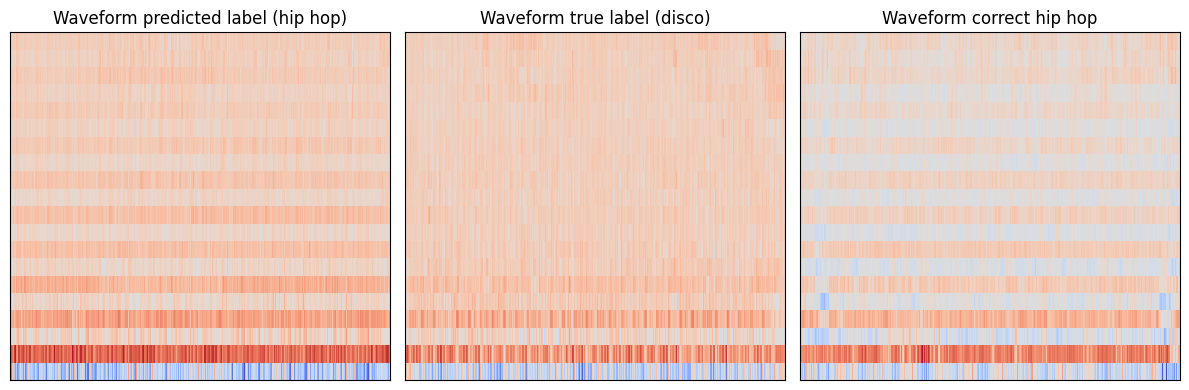

In [ ]:
print(f'Ground truth: {y_test_classes[w1]}, predicted {y_pred_classes[w1]}')
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

librosa.display.specshow(librosa.feature.mfcc(y=audio1), sr=sampling_rate, ax=ax[0])
ax[0].set_title("Waveform predicted label (hip hop)")

librosa.display.specshow(librosa.feature.mfcc(y=df['train'][9]['audio']['array']), sr=sampling_rate, ax=ax[1])
ax[1].set_title("Waveform true label (disco)")

librosa.display.specshow(librosa.feature.mfcc(y=df['test'][89]['audio']['array']), sr=sampling_rate, ax=ax[2])
ax[2].set_title("Waveform correct hip hop")

plt.tight_layout()
plt.show()